Consider the case in which all the users belong to class C1, and no information about the advertising and pricing curves is known beforehand. Apply the GP-UCB and GP-TS algorithms when using GPs to model the two advertising curves, reporting the plots of the average (over a sufficiently large number of runs) value and standard deviation of the cumulative regret, cumulative reward, instantaneous regret, and instantaneous reward.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.User_Classes import UserClass
from utils.clairvoyant_tools import find_optimal_bid_for_class
from utils.tools import calculate_margin
from p3.pricing_enviroment import Princing_Environment_3
from p3.bidding_enviroment import Bidding_Environment_3
from p3.GPTS_learner import GPTS_Learner3
from p3.GPUCB_learner import GPUCB_Learner3
from utils.learners.TS_Learner import TS_Learner

import warnings
warnings.filterwarnings("ignore")

# Environment

In [15]:
#Environment
n_arms = 100

prices = [50, 100, 150, 200, 250]
bids = np.linspace(0.01, 3.0, n_arms)
clicks_sigma = 50
cost_sigma = 10

user = UserClass(name='C1')

T = 30
n_experiments = 8

gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []

opt_vec = []
for price_index in range(len(prices)):
    opt_vec.append(find_optimal_bid_for_class(user.user_index, price_index))

print(opt_vec) # reward of optimum bid
optimum_bid_reward = np.max(np.array(opt_vec))
print(optimum_bid_reward) #optimum bid

[(0.8556565656565658, 1603.8005474787692), (1.0972727272727274, 4732.185994077948), (1.1274747474747475, 5080.849095727814), (1.0670707070707073, 4035.2367668011466), (1.036868686868687, 3338.9019124423953)]
5080.849095727814


In [16]:
# Create Environment
pr_env = Princing_Environment_3(n_arms, user)
bid_env = Bidding_Environment_3(bids, clicks_sigma, cost_sigma, user, n_arms)

In [17]:
for e in tqdm(range(n_experiments), desc='Number of experiments'):
    # Create Learner
    pricing_learner = TS_Learner(len(prices))
    bidding_GPTS_learner = GPTS_Learner3(n_arms, arms=bids)
    ts_rewards = []

    # generate empty deque
    arms = []

    # Simulate experiments
    for d in range(T):
        # choose arms
        pricing_pulled_arm = pricing_learner.pull_arm()
        arms.append(pricing_pulled_arm)
        #Calculate the conversion rate of the price choose
        conv_rate = pricing_learner.beta_parameters[pricing_pulled_arm, 0] / (pricing_learner.beta_parameters[pricing_pulled_arm, 0]
            + pricing_learner.beta_parameters[pricing_pulled_arm, 1])

        #GPTS
        # Fixed the price, I can find the bid that maximize the expected reward
        bidding_pulled_arm = bidding_GPTS_learner.pull_arm(conv_rate=conv_rate, margin=calculate_margin(prices[pricing_pulled_arm]))
        # empty daily reward
        n_clicks, costperclick = bid_env.round(pulled_arm=bidding_pulled_arm)
        # how many successes?
        ts_successes = pr_env.round(user, pricing_pulled_arm, n_clicks)
        # update beta
        pricing_learner.update(pricing_pulled_arm, ts_successes)
        # Reward of the day
        daily_reward = ts_successes * calculate_margin(prices[pricing_pulled_arm]) - costperclick * n_clicks
        costs = costperclick * n_clicks
        bidding_GPTS_learner.update(pulled_arm=bidding_pulled_arm, costs=costs, clicks=n_clicks)
        # save daily reward
        ts_rewards.append(daily_reward)
        
    gpts_rewards_per_experiment.append(ts_rewards)

Number of experiments: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


In [18]:
for e in tqdm(range(n_experiments), desc='Number of experiments'):
    # Create Learner
    pricing_learner = TS_Learner(len(prices))
    bidding_GPUCB_learner = GPUCB_Learner3(n_arms, arms=bids)
    ucb_rewards = []

    # generate empty deque
    arms = []

    # Simulate experiments
    for d in range(T):
        # choose arms
        pricing_pulled_arm = pricing_learner.pull_arm()
        arms.append(pricing_pulled_arm)
        #Calculate the conversion rate of the price choose
        conv_rate =pricing_learner.beta_parameters[pricing_pulled_arm, 0] / (pricing_learner.beta_parameters[pricing_pulled_arm, 0]
            + pricing_learner.beta_parameters[pricing_pulled_arm, 1])

        #GPUCB
        # Fixed the price, I can find the bid that maximize the expected reward
        bidding_pulled_arm = bidding_GPUCB_learner.pull_arm(conv_rate=conv_rate, margin=calculate_margin(prices[pricing_pulled_arm]))
        # empty daily reward
        n_clicks, costperclick = bid_env.round(pulled_arm=bidding_pulled_arm)
        # how many successes?
        ucb_successes = pr_env.round(user, pricing_pulled_arm, n_clicks)
        # update beta
        pricing_learner.update(pricing_pulled_arm, ucb_successes)
        # Reward of the day
        daily_reward = ucb_successes * calculate_margin(prices[pricing_pulled_arm]) - costperclick * n_clicks
        costs = costperclick * n_clicks
        bidding_GPUCB_learner.update(pull_arm=bidding_pulled_arm, costs=costs, clicks=n_clicks)
        # save daily reward
        ucb_rewards.append(daily_reward)
        
    gpucb_rewards_per_experiment.append(ucb_rewards)

Number of experiments:   0%|          | 0/8 [00:00<?, ?it/s]

Number of experiments: 100%|██████████| 8/8 [00:12<00:00,  1.60s/it]


# Cumulative Regret

## TS & GPTS

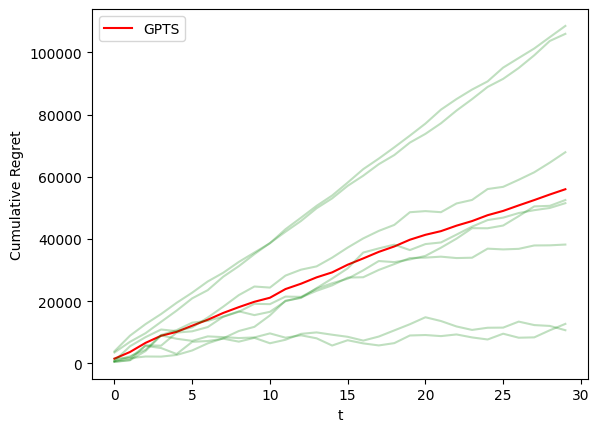

In [19]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid_reward - gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(optimum_bid_reward- line, axis=0), "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

## TS & GPUCB

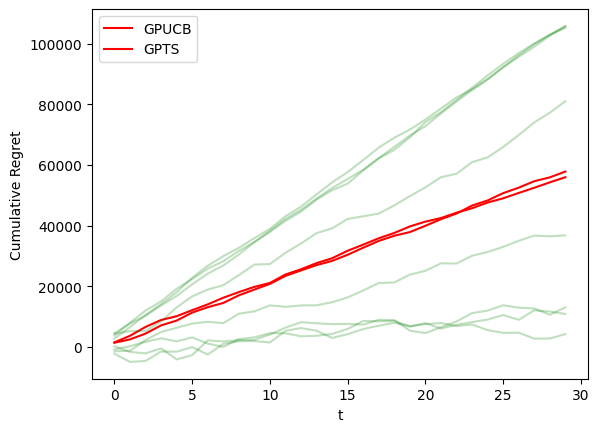

In [27]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid_reward - gpucb_rewards_per_experiment, axis=0)), 'r', label='GPUCB')
plt.plot(np.cumsum(np.mean(optimum_bid_reward - gpts_rewards_per_experiment, axis=0)), 'b', label='GPTS')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(np.nancumsum(optimum_bid_reward - line, axis=0), "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

# Cumulative Reward

## TS & GPTS

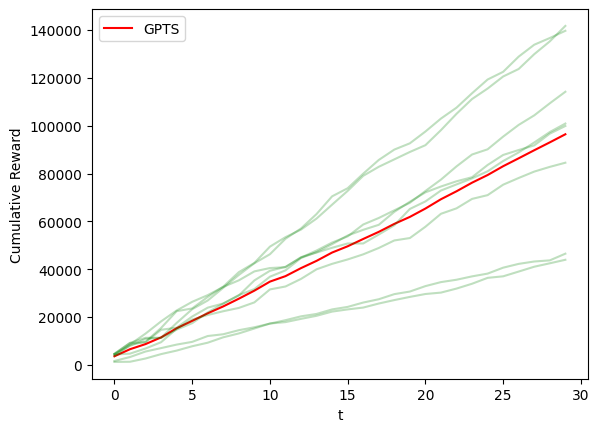

In [21]:
plt.figure(0)
plt.ylabel("Cumulative Reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(line, axis=0), "g", alpha=1 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

## TS & GPUCB

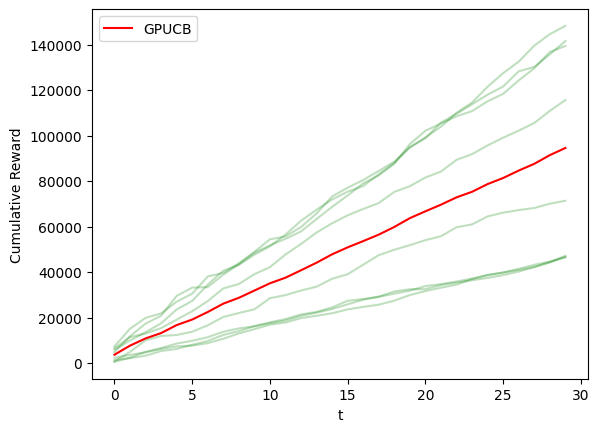

In [22]:
plt.figure(0)
plt.ylabel("Cumulative Reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpucb_rewards_per_experiment, axis=0)), 'r', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(np.nancumsum(line, axis=0), "g", alpha=1 / np.power(len(gpucb_rewards_per_experiment), 2/3))

plt.legend()
plt.show()

# Istantaneous Regret

## TS & GPTS

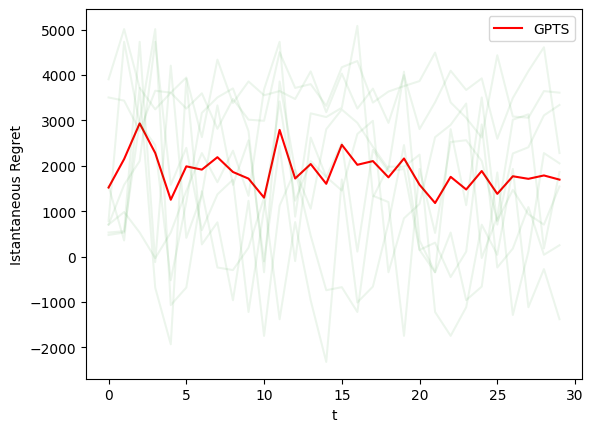

In [23]:
plt.figure(0)
plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(np.mean(optimum_bid_reward - gpts_rewards_per_experiment, axis=0), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(optimum_bid_reward - line, "g",  alpha=0.3 / np.power(len(gpts_rewards_per_experiment) , 2/3))
plt.legend()
plt.show()

## TS & GPUCB

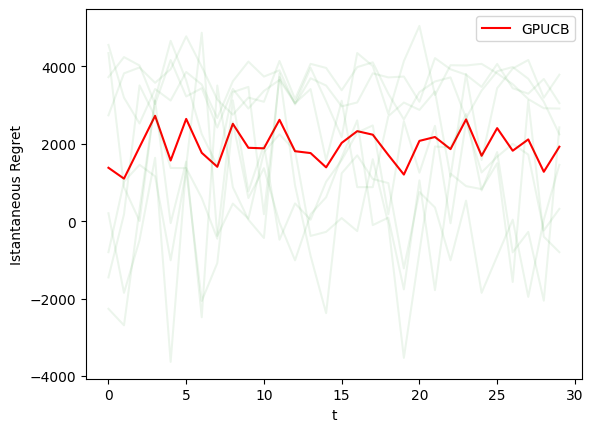

In [24]:
plt.figure(0)
plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(np.mean(optimum_bid_reward - gpucb_rewards_per_experiment, axis=0), 'r', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(optimum_bid_reward - line, "g",  alpha=0.3 / np.power(len(gpucb_rewards_per_experiment) , 2/3))
plt.legend()
plt.show()

# Instantaneous Reward

## TS & GPTS

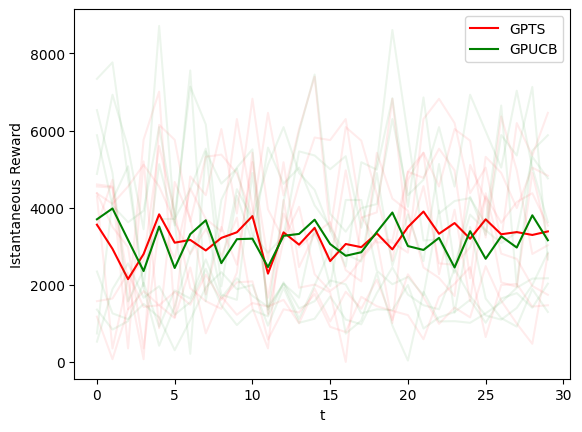

In [25]:
plt.figure(0)
plt.ylabel("Istantaneous Reward")
plt.xlabel("t")
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0), 'r', label='GPTS')
for line in gpts_rewards_per_experiment:
    plt.plot(line, "r", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))

plt.plot(np.mean(gpucb_rewards_per_experiment, axis=0), 'g', label='GPUCB')
for line in gpucb_rewards_per_experiment:
    plt.plot(line, "g", alpha=0.3 / np.power(len(gpucb_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

## TS & GPUCB

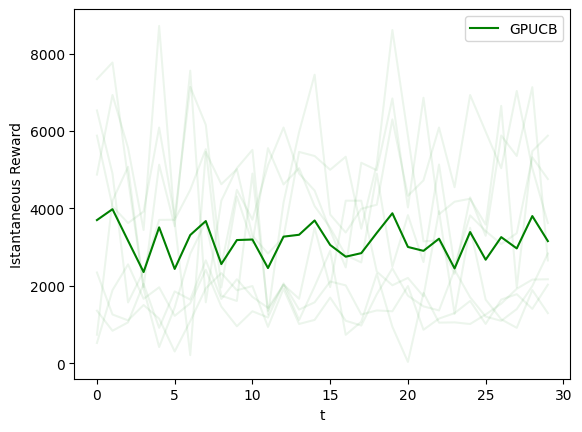

In [26]:
plt.figure(0)
plt.ylabel("Istantaneous Reward")
plt.xlabel("t")
plt.plot(np.mean(gpucb_rewards_per_experiment, axis=0), 'g', label='GPUCB')
for line in gpucb_rewards_per_experiment:
    plt.plot(line, "g", alpha=0.3 / np.power(len(gpucb_rewards_per_experiment), 2/3))
plt.legend()
plt.show()